# Neural Network from Scratch (No TensorFlow/PyTorch)

This notebook implements a simple 2-layer Neural Network to classify MNIST digits using only **NumPy**.
We will manually implement:
- Forward Propagation (Dot products, Activation functions)
- Backward Propagation (Derivatives, Chain Rule)
- Gradient Descent Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.random.seed(42)

## 1. Data Loading
We use Scikit-Learn to fetch the MNIST dataset.

In [2]:
print("Loading MNIST (via Keras due to OpenML instability)...")
from tensorflow.keras.datasets import mnist
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
# Flatten images
X = np.concatenate([x_train_raw.reshape(-1, 784), x_test_raw.reshape(-1, 784)])
y = np.concatenate([y_train_raw, y_test_raw])
print("Data Loaded:", X.shape)

Loading MNIST (via Keras due to OpenML instability)...
Data Loaded: (70000, 784)


## 2. Preprocessing
- Normalize pixel values to [0, 1].
- Transpose data so columns are examples (784, m).

In [3]:
# Normalize
X = X / 255.0

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Transpose for our Matrix math: Shape (Buffer_Size, Number_of_examples)
X_train = X_train_raw.T
X_test = X_test_raw.T

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

m_train = X_train.shape[1]

Train Shape: (784, 63000)
Test Shape: (784, 7000)


## 3. Mathematical Functions
$$ \text{ReLU}(Z) = \max(0, Z) $$
$$ \text{Softmax}(Z_i) = \frac{e^{Z_i}}{\sum e^{Z_j}} $$

In [4]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(10, 128) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    # Enforce 10 classes for MNIST
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    # Fix: sum across columns (axis=1) and keep dims for broadcasting
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    # Fix: sum across columns (axis=1) and keep dims
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

## 4. Training Loop

[2 0 6 ... 5 8 5] [8 7 6 ... 1 0 0]
Iteration 0: 0.0718
[2 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 50: 0.7707
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 100: 0.8279
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 150: 0.8533
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 200: 0.8696
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 250: 0.8798
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 300: 0.8880
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 350: 0.8942
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 400: 0.8993
[5 7 6 ... 1 0 0] [8 7 6 ... 1 0 0]
Iteration 450: 0.9040


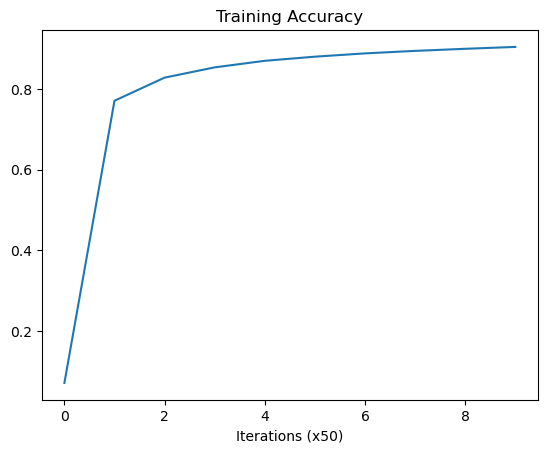

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    accuracy_history = []
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 50 == 0:
            acc = get_accuracy(get_predictions(A2), Y)
            print(f"Iteration {i}: {acc:.4f}")
            accuracy_history.append(acc)
            
    return W1, b1, W2, b2, accuracy_history

W1, b1, W2, b2, history = gradient_descent(X_train, y_train, 0.10, 500)

plt.plot(history)
plt.title("Training Accuracy")
plt.xlabel("Iterations (x50)")
plt.show()

## 5. Evaluation

Prediction:  [8]
Label:  8


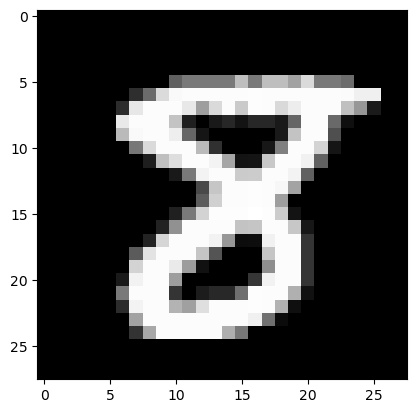

Prediction:  [4]
Label:  4


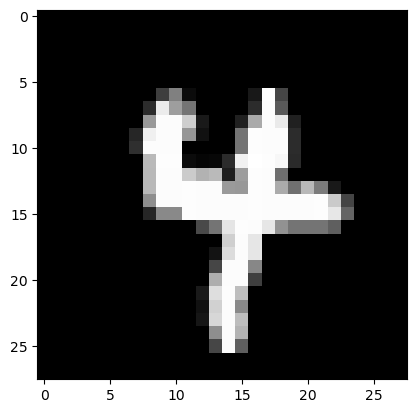

Prediction:  [5]
Label:  8


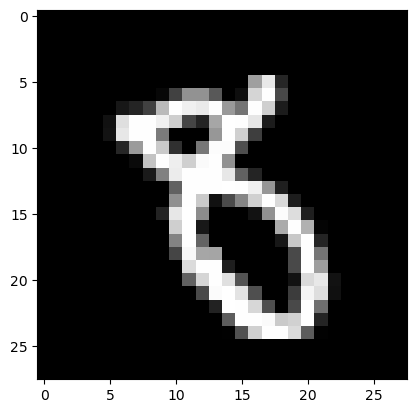

In [6]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_test[:, index, None]
    prediction = make_predictions(X_test[:, index, None], W1, b1, W2, b2)
    label = y_test[index]
    
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)

In [7]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
print("Test Accuracy:", get_accuracy(dev_predictions, y_test))

[8 4 5 ... 5 2 6] [8 4 8 ... 5 2 6]
Test Accuracy: 0.9038571428571428
